In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Dense, Dropout,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import matplotlib.pyplot as plt

In [105]:
# Parameters
IMG_SIZE = (128, 128)  # Size for autoencoder
EFFICIENTNET_SIZE = (224, 224)  # Adjusted size for EfficientNetB0
BATCH_SIZE = 32
EPOCHS = 5
ENCODED_SHAPE = (16, 16, 128)  # Encoded size from autoencoder
CLASSES = 2 
EFFICIENTNET_SIZE = (224, 224, 3)

In [3]:
# Directory paths
train_dir = 'D:/Deep learning/Datasets/train'  # Replace with your actual train directory
val_dir = 'D:/Deep learning/Datasets/validation'  # Replace with your actual validation directory


In [4]:
# Data generators for training autoencoder
datagen = ImageDataGenerator(rescale=1./255)

train_gen_autoencoder = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='input',
    shuffle=True
)

val_gen_autoencoder = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='input',
    shuffle=False
)

Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


In [5]:
# Visualize Sample of Original Dataset Images
def visualize_original_images(generator, num_images=5):
    original_images, _ = next(generator)
    
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title("Original Image")
    plt.show()

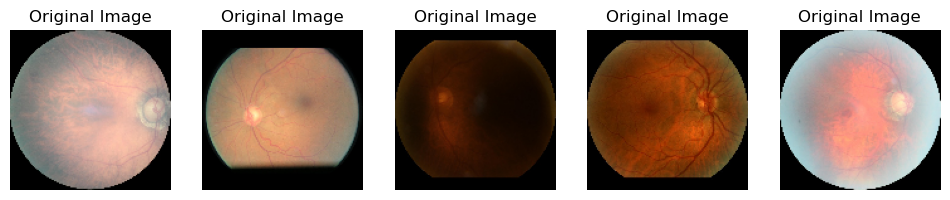

In [6]:
# Display original images from the dataset
visualize_original_images(train_gen_autoencoder)

In [7]:
# Build Autoencoder Model
input_img = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [8]:

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
history_autoencoder = autoencoder.fit(train_gen_autoencoder, epochs=EPOCHS, validation_data=val_gen_autoencoder)


Epoch 1/5


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 703ms/step - loss: 0.0256 - val_loss: 0.0017
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 172s 680ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 147s 580ms/step - loss: 0.0012 - val_loss: 8.9467e-04
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 148s 586ms/step - loss: 9.1353e-04 - val_loss: 8.9624e-04
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 149s 588ms/step - loss: 8.5772e-04 - val_loss: 7.1728e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


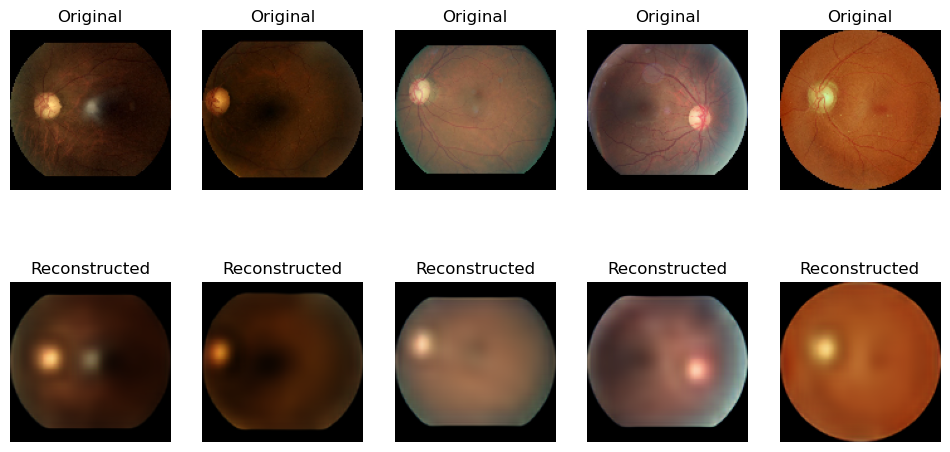

In [10]:
# Visualize Images Before and After Autoencoder
def visualize_reconstructed_images(generator, autoencoder_model, num_images=5):
    original_images, _ = next(generator)
    reconstructed_images = autoencoder_model.predict(original_images)
    
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title("Original")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
        plt.title("Reconstructed")
        
    plt.show()

# Display a sample of reconstructed images
visualize_reconstructed_images(train_gen_autoencoder, autoencoder)

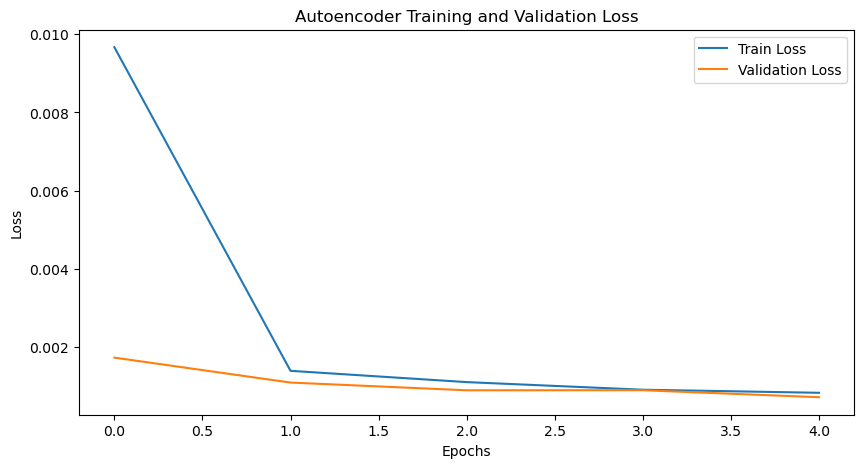

In [11]:
# Plot Autoencoder Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history_autoencoder.history['loss'], label='Train Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
# Updated EfficientNetB3 Model for Encoded Input
def create_efficientnetb3(input_shape, num_classes):
    # Input layer for encoded features
    input_layer = Input(shape=input_shape)
    x = Conv2D(3, (1, 1), activation='relu')(input_layer)  # Reduce channels to 3

    # Use upsampling to match EfficientNet's input size
    x = UpSampling2D(size=(14, 14))(x)  # Upsample (16, 16) to (224, 224)

    # Load EfficientNetB3 base model
    base_model = EfficientNetB3(include_top=False, input_shape=EFFICIENTNET_SIZE, weights='imagenet')
    x = base_model(x, training=False)

    # Add custom layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the EfficientNetB3 model
efficientnet_model = create_efficientnetb3(ENCODED_SHAPE, CLASSES)

In [111]:
# Function to Generate Encoded Data for EfficientNet
def generate_encoded_data(generator, autoencoder_model, num_samples):
    encoded_images = []
    labels = []
    total_samples = 0
    
    for images, label in generator:
        encoded_batch = autoencoder_model.predict(images)
        encoded_images.append(encoded_batch)
        labels.append(label)
        
        total_samples += images.shape[0]
        if total_samples >= num_samples:
            break
    
    encoded_images = np.vstack(encoded_images)[:num_samples]  # Ensure correct shape
    labels = np.hstack(labels)[:num_samples]
    
    return encoded_images, labels

In [112]:
# Generate Encoded Features for Training and Validation
num_samples = 200
encoded_train_images, train_labels = generate_encoded_data(train_gen_autoencoder, autoencoder, num_samples)
encoded_val_images, val_labels = generate_encoded_data(val_gen_autoencoder, autoencoder, num_samples // 4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Epoch 1/5


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1967s 2s/step - accuracy: 0.7015 - loss: 0.5892 - val_accuracy: 0.8906 - val_loss: 0.3090
Epoch 2/5


C:\Users\DELL\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1371
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1871s 2s/step - accuracy: 0.8505 - loss: 0.3711 - val_accuracy: 0.8477 - val_loss: 0.3376
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1287
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1873s 2s/step - accuracy: 0.8622 - loss: 0.3363 - val_accuracy: 0.8828 - val_loss: 0.2628


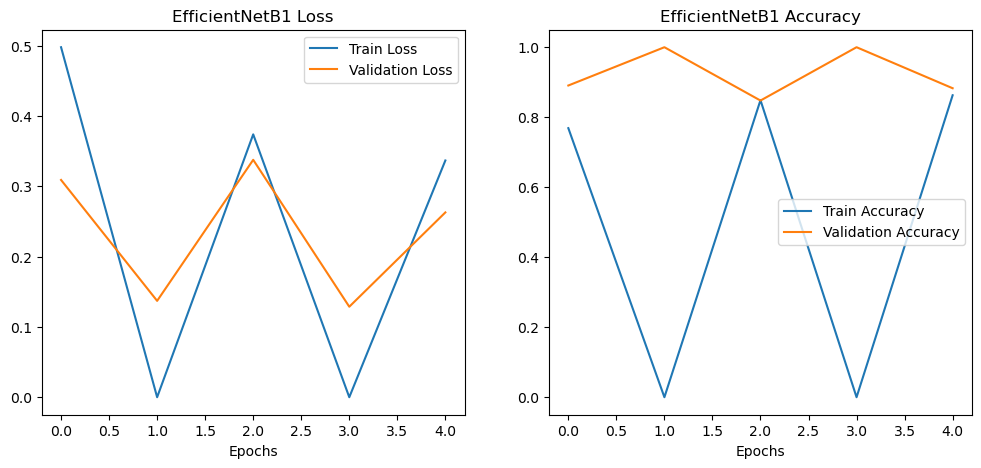

In [123]:
# Your dataset details
train_samples = 8000  # Total training images
val_samples = 770     # Total validation images

# Training and validation image generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory to load and resize images
train_gen_autoencoder = train_datagen.flow_from_directory('D:/Deep learning/Datasets/train', target_size=IMG_SIZE,
                                                          batch_size=BATCH_SIZE, class_mode='binary')
val_gen_autoencoder = val_datagen.flow_from_directory('D:/Deep learning/Datasets/validation', target_size=IMG_SIZE,
                                                      batch_size=BATCH_SIZE, class_mode='binary')

# Train EfficientNetB1 Model on resized images
history = efficientnet_model.fit(
    train_gen_autoencoder, epochs=EPOCHS, validation_data=val_gen_autoencoder,
    steps_per_epoch=train_samples // BATCH_SIZE,  # 1000 steps per epoch
    validation_steps=val_samples // BATCH_SIZE  # 96 validation steps
)

# Plot EfficientNetB1 Training Loss and Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB1 Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB1 Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step


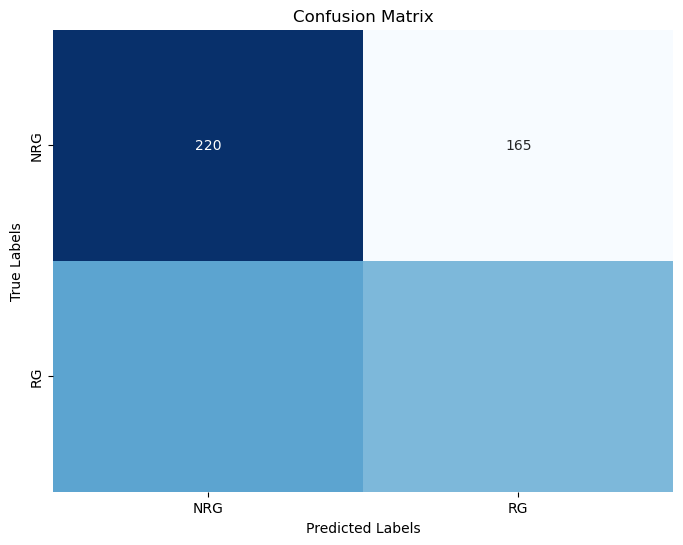

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict on validation data
val_gen_autoencoder.reset()  # Reset generator to avoid shuffling issues
predictions = efficientnet_model.predict(val_gen_autoencoder, steps=val_gen_autoencoder.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Get true labels
true_classes = val_gen_autoencoder.classes

# Step 3: Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=val_gen_autoencoder.class_indices.keys(),
            yticklabels=val_gen_autoencoder.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Image shape: (8, 224, 224, 3)
Image data type: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


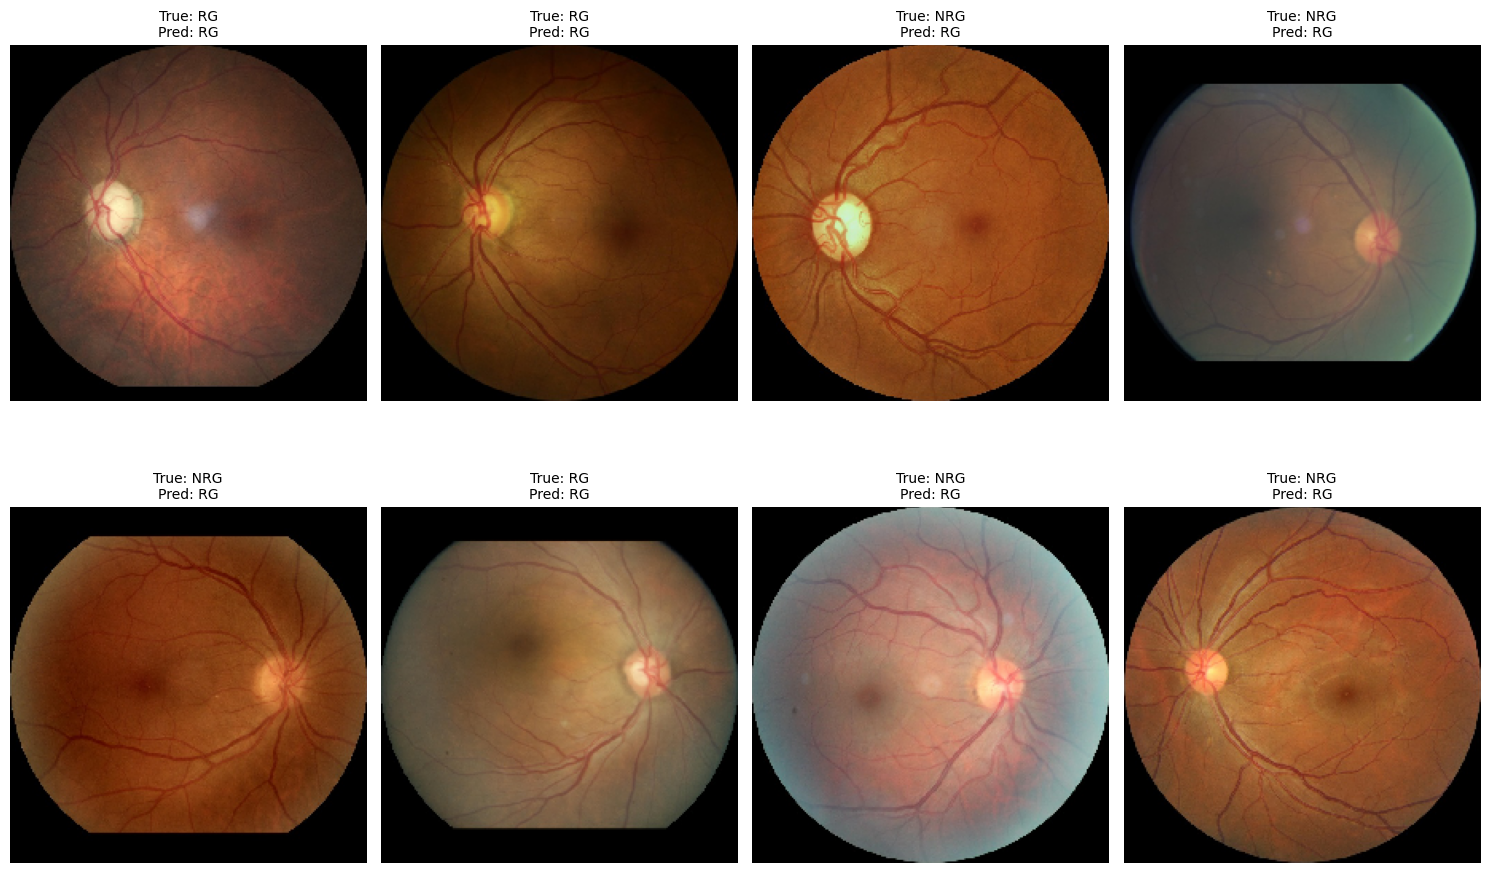

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure inline display in Jupyter notebooks
%matplotlib inline

# Define the number of images to display
num_images = 8

# Reset the generator and get a batch of images and labels
val_gen_autoencoder.reset()
images, true_labels = next(val_gen_autoencoder)

# Check image shape and data type
print("Image shape:", images.shape)
print("Image data type:", images.dtype)

# Convert images to uint8 if necessary
if images.dtype != np.uint8:
    images = (images * 255).astype("uint8")

# Get predictions for this batch
predictions = efficientnet_model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert class indices keys to a list
class_labels = list(val_gen_autoencoder.class_indices.keys())

# Ensure true_labels and predicted_labels are integers
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)



# Plot images with predicted and true labels
plt.figure(figsize=(15, 10))
for i in range(num_images):
    ax = plt.subplot(2, num_images // 2, i + 1)
    plt.imshow(images[i])  # Convert image format if necessary
    true_label = class_labels[true_labels[i]]
    pred_label = class_labels[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
